# Imports and function definitions

In [1]:
%matplotlib inline
import glob
import re
from os.path import basename, splitext, join
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import typhon.plots
from netCDF4 import Dataset

os.environ['PSRAD_PATH'] = '/scratch/uni/u237/users/lkluft/icon-aes/psrad/'
import conrad


plt.style.use(typhon.plots.styles('typhon'))


def get_legend_label(filename, label=None, **kwargs):
    """Get label for legend entry."""
    finfo = conrad.utils.extract_metadata(filename)
    
    if 'layer' in finfo.experiment:
        label = f'{finfo.scale:>5} layers'
    elif 'co2' in finfo.experiment or 'shift' in finfo.experiment:
        label = rf'$CO_2 \times {finfo.scale}$'
    elif label is None:
        label = basename(filename)
    else:
        label = basename(filename)
    
    return label
    
    
def running_mean(x, N):
    """Calculate a running mean over a given data array.
    
    Paramters:
        x (ndarray): Data array.
        N (int): Window size.
    
    Return:
        ndarray: Running mean.
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 


def calculate_toa(data):
    """Calculate radiation budget at top of the atmosphere (TOA).
    
    Parameters:
        data (dict): Dictionary containing short- and longwave fluxes.
        
    Returns:
        ndarray: Radiation budget at TOA.
    """
    lw_flxu = data.variables['lw_flxu'][:, -1]
    lw_flxd = data.variables['lw_flxd'][:, -1]
    sw_flxu = data.variables['sw_flxu'][:, -1]
    sw_flxd = data.variables['sw_flxd'][:, -1]
    return ((sw_flxd + lw_flxd) - (sw_flxu + lw_flxu))

def scale_getter(filename):
    return float(conrad.utils.extract_metadata(filename).scale)

# Surface temperature and radiation budget

Read results/secondmax/shift-rh/secondmax_shift-rh_4.nc...
Read results/secondmax/shift-rh/secondmax_shift-rh_2.nc...
Read results/secondmax/shift-rh/secondmax_shift-rh_1.nc...
Read results/secondmax/shift-rh/secondmax_shift-rh_0.5.nc...


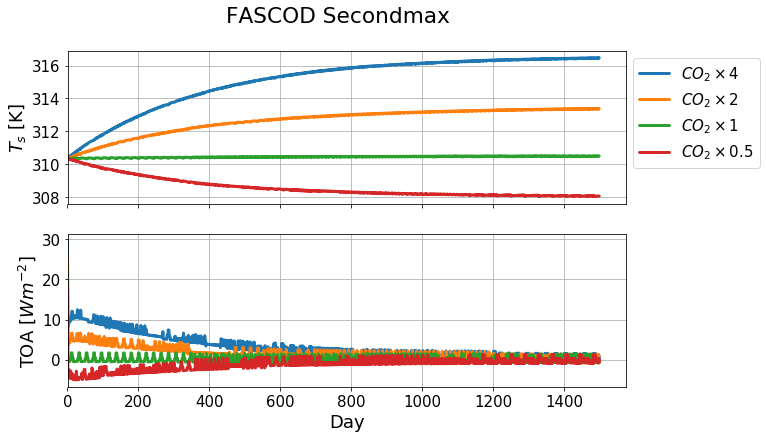

In [2]:
atmosphere='secondmax'
experiment='shift-rh'
scale = '*'
extra=''
result_dir='results/'
plot_dir = 'plots/'
    
filepattern = conrad.utils.get_filepath(
    atmosphere=atmosphere,
    experiment=experiment,
    scale=scale,
    extra=extra,
    result_dir=result_dir,
    create_tree=False,
)

scenarios = sorted(glob.glob(filepattern), key=scale_getter, reverse=True)

# Select sub-group
# scenarios = [s for s in scenarios if conrad.utils.extract_metadata(s).scale in ['0.5', '1', '2', '4', '8']]

if len(scenarios) == 0:
    raise FileNotFoundError('No input files found. Probably screwed glob pattern.')

fig, [ax, ax2] = plt.subplots(nrows=2, sharex=True)
fig.suptitle('FASCOD {atmosphere}'.format(atmosphere=atmosphere.capitalize()))
for scenario in scenarios:
    data = Dataset(scenario)
    print(f'Read {scenario}...')
    time = data.variables['time'][:] / 24  # time in days
    
    # Read and plot surface temperatures.
    Ts = data.variables['temperature'][:]
    ax.plot(
        time, Ts,
        label=get_legend_label(scenario),
        linewidth=3,
    )
    
    # Calculate and plot radiation budget at top of the atmosphere.
    toa = calculate_toa(data)
    ax2.plot(
        time, toa,
        linewidth=3,
    )
    
ax.grid('on')
ax2.grid('on')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.set_xlabel('Day')
ax.set_xlim(left=1)
ax.set_ylabel('$T_s$ [K]')
ax2.set_ylabel('TOA [$Wm^{-2}$]')
# ax2.set_ylim(-1, 6)
# ax.set_ylim(309, 313.5)
fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_t_surface.pdf'))

## Running mean over radiation budget

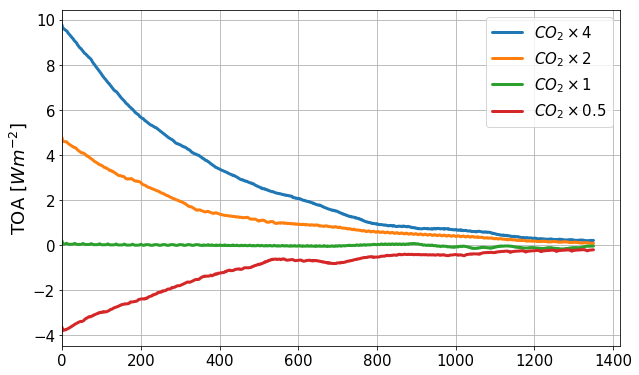

In [3]:
average_window = int(30 / 0.2)

fig, ax = plt.subplots()
for scenario in scenarios:
    data = Dataset(scenario)
    ax.plot(
        # time[:-average_window+1],
        running_mean(calculate_toa(data), average_window),
        linewidth=3,
        label=get_legend_label(scenario),
    )
ax.legend()
ax.grid(True)
ax.set_xlim(left=0)
# ax.set_xlabel('Day')
ax.set_ylabel('TOA [$Wm^{-2}$]')
fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_toa_runningmean.pdf'))

# Plot equilibrium temperature profiles

## Pressure coordinates

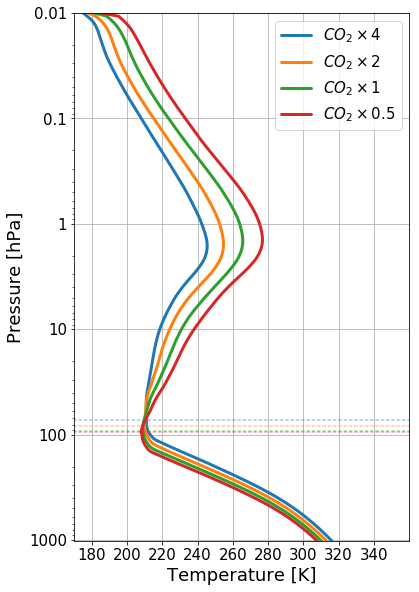

In [4]:
fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
for scenario in scenarios:
    data = Dataset(scenario)
    p = data.variables['plev'][:]
    T = data.variables['T'][-1, :]
    ci = np.argmin(T[p>10e2])
    
    l = typhon.plots.profile_p_log(
        p, T,
        label=get_legend_label(scenario),
        linewidth=3,
        )
    ax.axhline(p[ci], linestyle='dotted', color=l[0].get_color(), alpha=0.3)
    
# ax.set_title(f'FASCOD {atmosphere.capitalize()}')
ax.grid('on')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(loc='upper right')# , bbox_to_anchor=(1, 1))
ax.set_xlabel('Temperature [K]')
ax.set_ylim(top=p.min(), bottom=p.max())
ax.set_xlim(left=170, right=360)
ax.set_xticks(np.arange(180, 341, 20))
# fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_t_profile.pdf'))
fig.savefig(join(plot_dir, f't_profile_presentation.pdf'))

## Geopotential coordinates

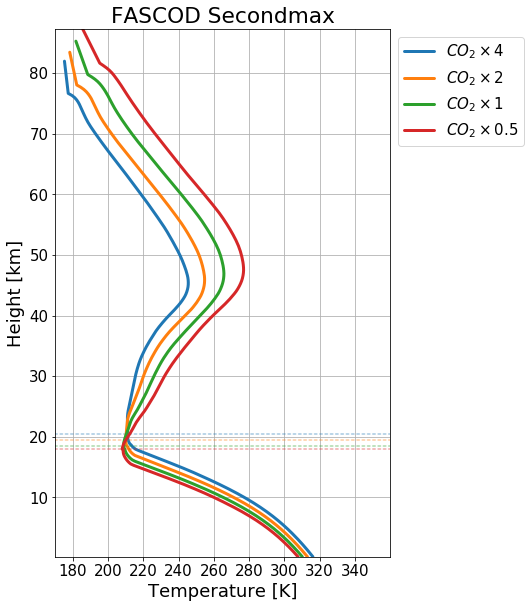

In [5]:
fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
for scenario in scenarios:
    data = Dataset(scenario)
    z = np.array(data.variables['z'])[-1, :]
    T = data.variables['T'][-1, :]
    ci = np.argmin(T[z<50e3])
    
    l = typhon.plots.profile_z(
        z, T,
        label=get_legend_label(scenario),
        linewidth=3,
        )
    ax.axhline(z[ci], linestyle='dotted', color=l[0].get_color(), alpha=0.3)
    
ax.set_title(f'FASCOD {atmosphere.capitalize()}')
ax.grid('on')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Temperature [K]')
ax.set_ylim(bottom=z.min(), top=z.max())
ax.set_xlim(left=170, right=360)
ax.set_xticks(np.arange(180, 341, 20))
fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_t_profile_z.pdf'))

# FAT mechanism

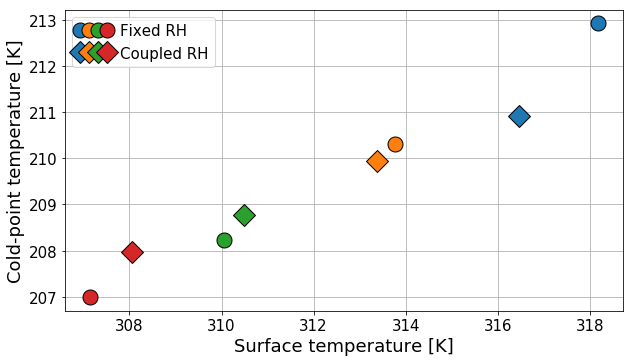

In [6]:
from itertools import cycle

from matplotlib.legend_handler import HandlerTuple


fig, ax = plt.subplots()
colors = cycle(f'C{i}' for i in range(4))
handle_groups = []
for experiment, marker in zip(['fixed-rh', 'shift-rh'], ['o', 'D']):
    filepattern = conrad.utils.get_filepath(
        atmosphere=atmosphere,
        experiment=experiment,
        scale=scale,
        extra=extra,
        result_dir=result_dir,
        create_tree=False,
    )

    handles = []
    for scenario in sorted(glob.glob(filepattern), key=scale_getter, reverse=True):
        data = Dataset(scenario)
        t_surface = data.variables['temperature'][-1]
        plev = data.variables['plev'][:]
        T = data.variables['T'][-1, :]
        t_cold_point = T[np.argmin(T[plev > 1e2])]
        t_convective_top = T[data.variables['convective_top'][-1]]
        handle, = ax.plot(t_surface, t_cold_point,
                marker=marker,
                markeredgecolor='k',
                markersize=15,
                linestyle='none',
                color=next(colors),
                label=get_legend_label(scenario))
        handles.append(handle)
    handle_groups.append(handles)
ax.grid(True)
ax.legend([tuple(g) for g in handle_groups], ['Fixed RH', 'Coupled RH'],
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_aspect('equal')
ax.set_xlabel('Surface temperature [K]')
ax.set_ylabel('Cold-point temperature [K]')
# ax.set_title('Cold-point temperature')
fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_cold_point_temperature.pdf'))

# Plot changes in water vapor mixing ratios

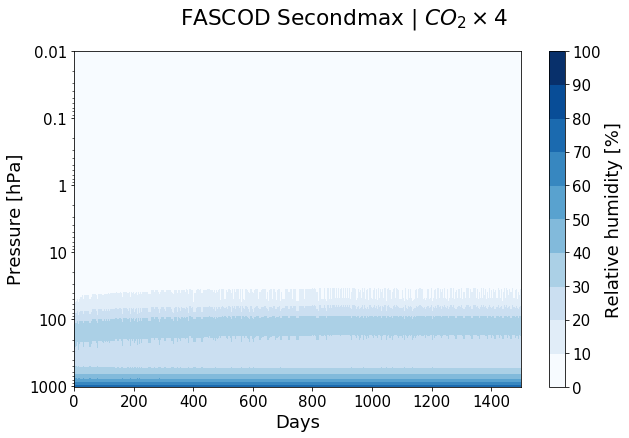

In [7]:
scenario = scenarios[0]

fig, ax = plt.subplots()
scale = conrad.utils.extract_metadata(scenario).scale
fig.suptitle(rf'FASCOD {atmosphere.capitalize()} | {get_legend_label(scenario)}')
data = Dataset(scenario)
time = data.variables['time'][:] / 24  # time in days

# Calculate relative humidity.
q = data.variables['H2O'][:]
p = data.variables['plev'][:]
T = data.variables['T'][:]
RH = 100* typhon.atmosphere.relative_humidity(q, p, T)

sm = ax.pcolormesh(
    time, p, RH.T,
    cmap=plt.get_cmap('Blues', 10),
    rasterized=True,
    vmin=0,
    vmax=100,
)
cb = fig.colorbar(sm, label='Relative humidity [%]')
cb.set_ticks(np.arange(0, 101, 10))
ax.invert_yaxis()
ax.set_yscale('log')
ax.set_ylabel('Pressure [hPa]')
ax.set_ylim(p.max(), p.min())
ax.set_xlabel('Days')
ax.yaxis.set_major_formatter(typhon.plots.HectoPascalLogFormatter())
ax.yaxis.set_minor_formatter(typhon.plots.HectoPascalLogFormatter())

# Layer thickness

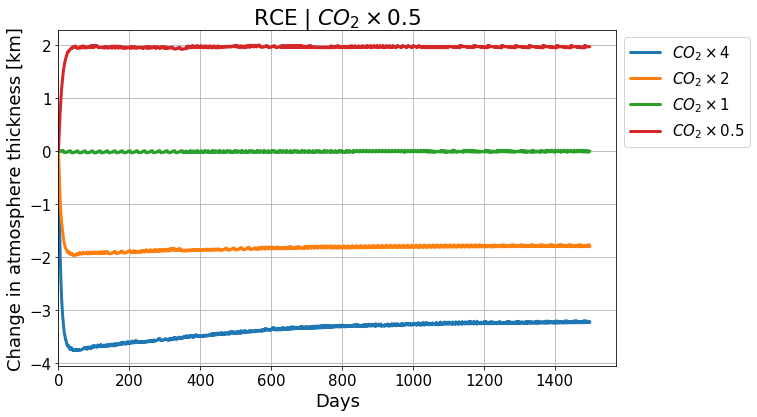

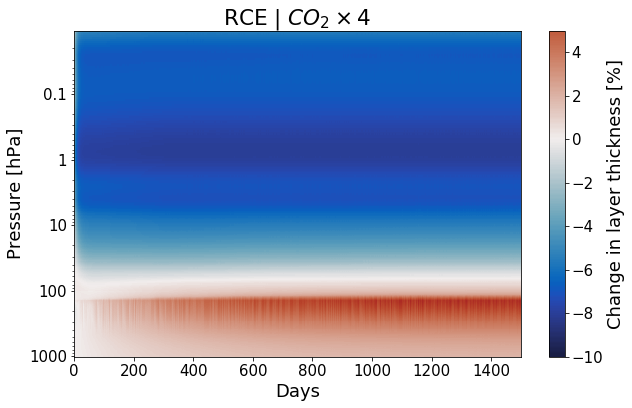

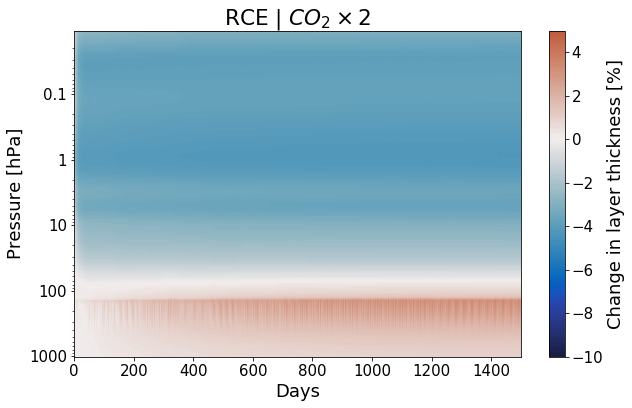

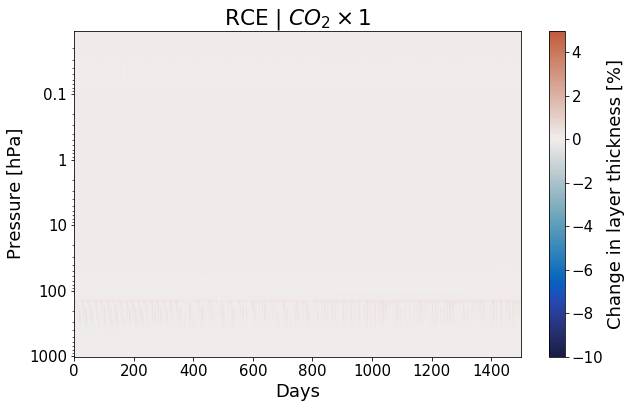

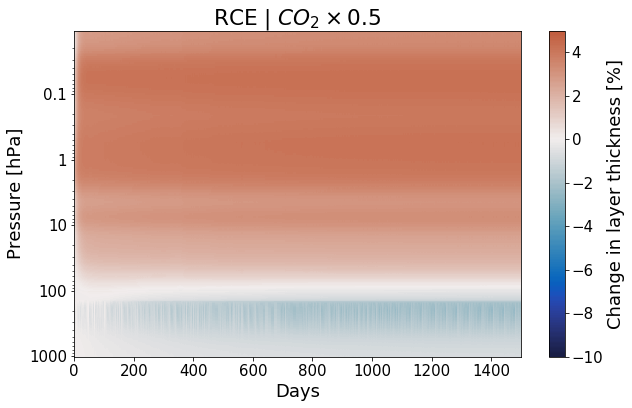

In [8]:
fig2, ax2 = plt.subplots()
for scenario in scenarios:
    dataset = Dataset(scenario)

    plev = dataset.variables['plev'][:]
    phlev = dataset.variables['phlev'][:]
    time = dataset.variables['time'][:] / 24
    T_field = dataset.variables['T'][:]
    rho_field = typhon.physics.density(plev, T_field)
    z_field = np.cumsum(-np.diff(phlev) / (rho_field * typhon.constants.g), axis=1)
    thickness = np.diff(z_field, axis=1)

    fig, ax = plt.subplots(figsize=(10, 6))
    change_in_thickness = thickness - thickness[0, :]
    rel_change_in_thickness = (thickness - thickness[0, :]) / thickness[0, :] * 100
    sm = ax.pcolormesh(time, plev[:-1], rel_change_in_thickness.T[:, :-1],
                       cmap='difference', rasterized=True, vmin=-10, vmax=5)
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_ylabel('Pressure [hPa]')
    ax.set_ylim(plev.max(), plev[:-1].min())
    ax.set_xlabel('Days')
    ax.set_xlim(left=0)
    ax.yaxis.set_major_formatter(typhon.plots.HectoPascalLogFormatter())
    ax.yaxis.set_minor_formatter(typhon.plots.HectoPascalLogFormatter())
    cb = fig.colorbar(sm, label='Change in layer thickness [%]')
    cb.set_clim(-10, 10)
    typhon.plots.center_colorbar(cb)
    ax.set_title(rf'RCE | {get_legend_label(scenario)}')
    scale = conrad.utils.extract_metadata(scenario).scale
    # fig.savefig(join(plot_dir, f'{atmosphere}_{experiment}_{scale}_layer_thickness.pdf'))

    ax2.plot(time, np.sum(change_in_thickness.T, axis=0) / 1e3,
             linewidth=3,
             label=get_legend_label(scenario))
    
ax2.set_title(rf'RCE | {get_legend_label(scenario)}')
ax2.set_ylabel('Change in atmosphere thickness [km]')
ax2.set_xlabel('Days')
ax2.set_xlim(left=0)
ax2.grid(True)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
# fig2.savefig(join(plot_dir, f'{atmosphere}_{experiment}_atmosphere_thickness.pdf'))